In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

# 一、构象生成算法概述

先来了解两种rdkit生成3D构象的方法：

## 1.基于距离（distance-based）

传统的距离几何（Distance Geometry）法生成构象步骤：
* (1) 通过分子的连接表信息和一套规则，生成分子的连接边界矩阵（molecule’s distance bounds matrix ）
* (2) 使用三角形边界平滑算法（triangle-bounds smoothing algorithm），对边界矩阵进行平滑处理
* (3) 根据边界矩阵，随机产生一个距离矩阵。
* (4) 把产生的距离矩阵映射到三维空间中，并为每个原子计算坐标。
* (5) 对计算的坐标结果使用力场和边界矩阵进行粗略的优化。

## 2.基于知识（knowledge-based）

Riniker和Landrum开发了一种（Experimental-Torsion Basic Knowledge Distance Geometry，ETKDG）的方法。他们从晶体结构数据库的小分子结构中总结了一些规则（扭转角的倾向性，torsion angle preference，符合某种SMARTS的结构更倾向于生成某种固定的构象），并用这套规则来修正距离几何算法产生的构象。如果使用了ETKDG，就可以不再使用力场进行优化了。

在rdkit中，目前已经将ETKDG作为默认的构象生成方法。使用代码实现这种方法比上面的废话都要简单，两行代码就能搞定了。

In [ ]:
m3d=Chem.AddHs(m)
AllChem.EmbedMolecule(m3d, randomSeed=1)

# 二、代码实现
* 添加氢原子
* 距离几何算法生成3D结构
* 距离几何+ETKDG生成3D构象
* 距离几何+ETKDG生成多构象
* 距离几何+ETKDG+MMFF生成3D构象
* 距离几何+ETKDG+MMFF生成多构象
* 多线程执行


## 1.添加氢原子

* **加氢：Chem.AddHs()**

在rdkit中，分子在默认情况下是不显示氢的，但氢原子对于真实的几何构象计算有很大的影响，所以在计算3D构象前，需要使用Chem.AddHs()方法加上氢原子。
* **减氢：Chem.RemoveHs()**

相对应的，可以使用该方法把氢去除。

In [4]:
m = Chem.MolFromSmiles('CC1=CC=C(C=C1)NC2=C3C(=C(C=C2)NC4=CC=C(C=C4)C)C(=O)C5=CC=CC=C5C3=O')
m3d = Chem.AddHs(m)
print(m.GetNumAtoms(), m3d.GetNumAtoms())

32 54


## 2.距离几何算法生成3D结构
使用距离几何初始化3D坐标。
* **生成3D构象：AllChem.EmbedMolecule(mol, randomSeed, clearConfs, useExpTorsionAnglePrefs, useBasicKnowledge, ...)**<br />
mol：传入mol对象<br />
randomSeed：随机种子，方便结果重复<br />
clearConfs：清除已有构象，默认True<br />
useExpTorsionAnglePrefs和useBasicKnowledge两个参数即控制是否使用先验知识，默认都为True

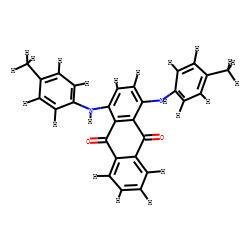

In [5]:
AllChem.EmbedMolecule(m3d, randomSeed=10, useExpTorsionAnglePrefs=False, useBasicKnowledge=False)
Draw.MolToImage(m3d, size=(250,250))

## 3.距离几何+ETKDG生成3D构象

* **生成3D构象：AllChem.EmbedMolecule()**<br />
先用距离几何初始化3D坐标，再使用ETKDG算法优化<br />
参数同上，默认useExpTorsionAnglePrefs和useBasicKnowledge为True

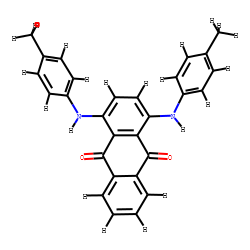

In [6]:
AllChem.EmbedMolecule(m3d, randomSeed=10)
Draw.MolToImage(m3d, size=(250,250))

## 4.距离几何+ETKDG生成多构象
无论使用哪种方法，都可以对一个分子生成许多构象，实现也很简单，无非使用不同的随机种子，多跑几次距离几何的计算过程就行了。
* **生成多个构象：AllChem.EmbedMultipleConfs(mol, numConfs, maxAttempts, randomSeed, clearConfs, pruneRmsThresh, useExpTorsionAnglePrefs, useBasicKnowledge, ...)**<br />
其中numConfs控制了生成构象的个数。<br />
mol：mol对象<br />
numConfs：生成的构象数量<br />
maxAttempts：尝试生成构象的最多次数<br />
randomSeed：随机种子<br />
clearConfs：清除已有构象<br />
pruneRmsThresh：根据RMS进行合并<br />
ETKDG相关参数同上

In [7]:
cids = AllChem.EmbedMultipleConfs(m3d, numConfs=10)
print(len(cids))

10


* **获取某个构象GetConformer(id)**<br />
通过传入id获取指定构象

In [8]:
conf1 = m3d.GetConformer(id=1)

* **计算不同构象间的差异：AlignMolConformers(mol, RMSlist, ...)**<br />
对同一分子不同的构象先进行重叠排列，再计算RMS（root mean square）值<br />
RMSlist：用于接收RMS的列表，它由第一个构象与剩余9个构象依次比对产生

In [9]:
rmslist = []
AllChem.AlignMolConformers(m3d, RMSlist=rmslist)
print(len(rmslist))

9


* **也可以计算任意两个指定构象的RMS值：GetConformerRMS(mol, confId1, confId2, atomIds, prealigned)**<br />
confId1：第一个构象<br />
confId2：第二个构象<br />
atomIds：需要对比的原子，默认全部<br />
prealigned：构象是否已经对齐，默认False（没有时，函数会自动将它们对齐）

In [10]:
AllChem.GetConformerRMS(m3d, 1, 9, prealigned=True)

1.5515373147254072

## 5.距离几何+ETKDG+MMFF生成3D构象
对距离几何产生的构象，进行ETKDG优化后，还可以继续使用MMFF94等力场进行优化。不过需要注意的是，MMFF力场中的原子类型编码采用了自身的芳香性模型，因此在使用MMFF相关方法后，分子的芳香属性（aromaticity flags）会改变。

* **使用MMFF94进行优化构象：MMFFOptimizeMolecule(mol, mmffVariant, maxIters, ...)**<br />
mmffVariant：可选"MMFF94"或"MMFF94s"，默认MMFF94<br />
maxIters：最多迭代次数，默认200

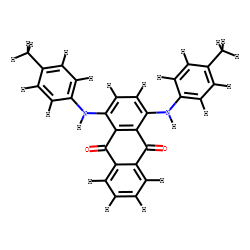

In [11]:
AllChem.EmbedMolecule(m3d, randomSeed=10)
AllChem.MMFFOptimizeMolecule(m3d)
Draw.MolToImage(m3d, size=(250,250))

## 6.距离几何+ETKDG+MMFF生成多构象
其实当使用ETKDG算法生成3D构象时，通常无需再使用MMFF94力场优化。如果执意要这么做，有一个方便的函数可以调用
* **使用MMFF94优化多个构象：MMFFOptimizeMoleculeConfs()**
* 返回的结果是元组组成的列表，每个元组表示每个构象的优化结果和能量(not_converged, energy)。如果not_converged是0，则收敛，接近最稳态，否则没有到达最稳态。

In [25]:
cids = AllChem.EmbedMultipleConfs(m3d, numConfs=10, randomSeed=5)
res = AllChem.MMFFOptimizeMoleculeConfs(m3d)
res

[(1, 102.41616335129055),
 (1, 102.33441584635808),
 (0, 102.42225287052568),
 (0, 102.32720200607255),
 (0, 102.33441556018424),
 (1, 102.41616372820093),
 (0, 102.4222529195194),
 (1, 102.33475547464988),
 (1, 102.33463971478054),
 (1, 102.32720685759661)]

* 可以看到部分构象还没有收敛，尝试把maxIters参数调高到500，全部收敛。

In [26]:
cids = AllChem.EmbedMultipleConfs(m3d, numConfs=10, randomSeed=5)
res = AllChem.MMFFOptimizeMoleculeConfs(m3d, maxIters=500)
res

[(0, 102.4161632241324),
 (0, 102.33441575541717),
 (0, 102.42225287052568),
 (0, 102.32720200607255),
 (0, 102.33441556018424),
 (0, 102.41616359925332),
 (0, 102.4222529195194),
 (0, 102.33441440334724),
 (0, 102.33441442488092),
 (0, 102.32720166633483)]

## 7.多线程
* EmbedMultipleConfs()
* MMFFOptimizeMoleculeConfs()<br />
默认情况下，这两个方法都是单进程。当想使用多进程时，可以通过numThreads参数进行设置。<br />
numThreads：默认为1。设置为0表示将会使用本机最大线程数执行

In [27]:
cids = AllChem.EmbedMultipleConfs(m3d, numThreads=0)
res = AllChem.MMFFOptimizeMoleculeConfs(m3d, numThreads=0)

# 三、结语

最后需要注意的是，构象生成是一项复杂且漫长的工作。rdkit生成的3D结构并不能取代真实的构象，它仅仅为需要3D结构的场景提供了一种快速实现的方法。不过，rdkit提供的ETKDG方法还是可以满足大多数3D需求场景的。